In [1]:
import cv2
import numpy as np
def read_image(image_path, grayscale=False):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if not grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

## 1

In [176]:
import numpy as np
import torch

def exposureRGB(img, R_a, R_b, G_a, G_b, B_a, B_b):
    #rgb_img = img.copy()
    rgb_img = img.clone()
    rgb_img[:, :, 0] = (rgb_img[:, :, 0]*R_a) + R_b
    rgb_img[:, :, 1] = (rgb_img[:, :, 1]*G_a) + G_b
    rgb_img[:, :, 2] = (rgb_img[:, :, 2]*B_a) + B_b
    
    #rgb_img = np.clip(rgb_img, 0, 1)
    rgb_img = torch.clamp(rgb_img, 0, 1)
    
    return rgb_img

def exposureRGB_Tens(inp, out_g):
    # Splitting the output tensor into individual parameter tensors
    R_a = out_g[:, 0, :, :]
    R_b = out_g[:, 1, :, :]
    G_a = out_g[:, 2, :, :]
    G_b = out_g[:, 3, :, :]
    B_a = out_g[:, 4, :, :]
    B_b = out_g[:, 5, :, :]

    # Applying the exposure transformation to the input image
    rgb_img = inp.clone()
    rgb_img[:, 0, :, :] = (inp[:, 0, :, :] * R_a) + R_b
    rgb_img[:, 1, :, :] = (inp[:, 1, :, :] * G_a) + G_b
    rgb_img[:, 2, :, :] = (inp[:, 2, :, :] * B_a) + B_b
    
    # Clipping the values to maintain the range [0, 1]
    rgb_img = torch.clamp(rgb_img, 0, 1)
    
    return rgb_img

In [177]:
class PSNR():
    def __init__(self):
        pass

    def adjust_dimensions(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        return x

    def __call__(self, ref, res):
        ref = self.adjust_dimensions(ref)
        res = self.adjust_dimensions(res)
        
        mse = torch.mean((ref - res) ** 2, dim=(1, 2, 3)) # mse for each element in the batch (b, c, h, w)
        psnr = 10 * torch.log10(1 / mse) # psnr for each mse in the batch

        return torch.mean(psnr)


In [178]:
import cv2
import numpy as np
def read_image(image_path, grayscale=False):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if not grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

In [179]:
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if 0 >= 0 else torch.FloatTensor

MSE Loss between Original and Transformed Image: 0.010080724954605103
MSE Loss between Transformed Image and Ground Truth: 0.010869323275983334


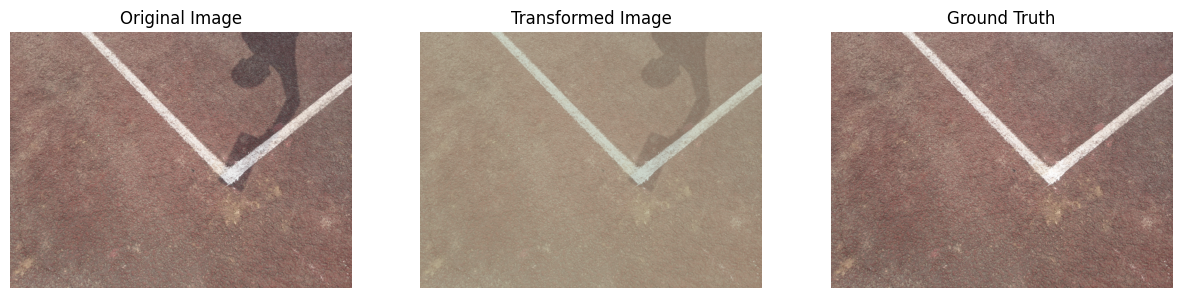

In [180]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Example paths (adjust as necessary)
path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/train/train_A/1-1.png'
path_gt = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/train/train_C/1-1.png'

# Read the original image and ground truth
img_original = read_image(path)
gt_original = read_image(path_gt)

# Convert numpy arrays to PyTorch tensors and ensure they're of type float
img_tensor = torch.from_numpy(img_original).float()
gt_tensor = torch.from_numpy(gt_original).float()

# Ensure img_tensor and gt_tensor have shape (C, H, W)
if img_tensor.ndimension() == 3 and img_tensor.shape[2] == 3:  # (H, W, C)
    img_tensor = img_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if gt_tensor.ndimension() == 3 and gt_tensor.shape[2] == 3:  # (H, W, C)
    gt_tensor = gt_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

# Now you can use tensors directly (Variables are deprecated)
img_variable = img_tensor

# Transform the original image (assuming exposureRGB returns a float32 image)
#img_transformed = exposureRGB(img_variable, 3, 10, 1, 0, 1, 0)0.4436, 0.3879, 0.5527, 0.3215, 0.5874, 0.2487
img_transformed = img_variable.clone()
img_transformed[0, :, :] = (img_transformed[0, :, :]*0.4436) + 0.3879
img_transformed[1, :, :] = (img_transformed[1, :, :]*0.5527) + 0.3215
img_transformed[2, :, :] = (img_transformed[2, :, :]*0.5874) + 0.2487
img_transformed = torch.clamp(img_transformed, 0, 1)

# Define the MSE loss function
loss_fn = nn.MSELoss()
PSNR_ = PSNR()

# Compute the MSE loss between the original and transformed images
loss_original_transformed = loss_fn(img_variable, img_transformed)

# Compute the MSE loss between the transformed image and the ground truth
loss_transformed_gt = loss_fn(img_transformed, gt_tensor)

# Print the losses
print(f'MSE Loss between Original and Transformed Image: {loss_original_transformed.item()}')
print(f'MSE Loss between Transformed Image and Ground Truth: {loss_transformed_gt.item()}')

# For visualization, convert tensors back to numpy arrays
img_original = img_variable.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
img_transformed_visual = img_transformed.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
gt_visual = gt_tensor.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Plot the images using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_original)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_transformed_visual)
axes[1].set_title('Transformed Image')
axes[1].axis('off')

axes[2].imshow(gt_visual)
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.show()

In [181]:
img_transformed[:, :, :].shape

torch.Size([3, 480, 640])

## 2

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import v2


In [2]:
import cv2
import numpy as np
def read_image(image_path, grayscale=False):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if not grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

In [6]:
def blur_image_border(image, border_mask, blur_kernel_size, sigma=1.0):
    blurred_combined = torch.empty_like(image) #image.clone()
    device = blurred_combined.device
    
    # Iterate over each image in the batch
    for i in range(image.size(0)):
        border_mask_i = border_mask[i, :, :, :].to(device)
        image_i = image[i, :, :, :].clone().to(device)
        blurrer = v2.GaussianBlur(kernel_size=(blur_kernel_size, blur_kernel_size), sigma=sigma)

        blurred_img = blurrer(image_i)

        blurred_combined[i, :, :, :] = image_i * (1 - border_mask_i) + blurred_img * border_mask_i

    blurred_combined = torch.clamp(blurred_combined, 0, 1)
    return blurred_combined

In [7]:
def dilate_erode_mask(mask, kernel_size=7):
    kernel = torch.ones((1, 1, kernel_size, kernel_size)).float()
    padding = kernel_size // 2
    
    eroded_mask = F.conv2d(mask.float(), kernel, padding=padding)
    eroded_mask = torch.where(eroded_mask >= kernel_size**2, 1.0, 0.0)
    eroded_mask = eroded_mask[:, :, :mask.size(2), :mask.size(3)]

    dilated_mask = F.conv2d(mask.float(), kernel, padding=padding)
    dilated_mask = torch.where(dilated_mask > 0, 1.0, 0.0)
    dilated_mask = dilated_mask[:, :, :mask.size(2), :mask.size(3)]

    return dilated_mask, eroded_mask

In [8]:
path = '/home/vhaardt/Desktop/ShadowRemoval/code/Shadow-Removal-1/example.png'
#'/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_A/123-1.png'
mask = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_B/123-1.png'
path_gt = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_C/123-1.png'

# Read the original image and ground truth
img_original = read_image(path)
img_mask = read_image(mask)[:,:,1]
gt_original = read_image(path_gt)

# Convert numpy arrays to PyTorch tensors and ensure they're of type float
img_tensor = torch.from_numpy(img_original).float()
m_tensor = torch.from_numpy(img_mask).float()
gt_tensor = torch.from_numpy(gt_original).float()

# Ensure img_tensor and gt_tensor have shape (C, H, W)
if img_tensor.ndimension() == 3 and img_tensor.shape[2] == 3:  # (H, W, C)
    img_tensor = img_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if m_tensor.ndimension() == 3 and m_tensor.shape[2] == 2:  # (H, W, C)
    m_tensor = m_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if gt_tensor.ndimension() == 3 and gt_tensor.shape[2] == 3:  # (H, W, C)
    gt_tensor = gt_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

[ WARN:0@69.435] global loadsave.cpp:248 findDecoder imread_('/home/vhaardt/Desktop/ShadowRemoval/code/Shadow-Removal-1/example.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [187]:
mask_exp = m_tensor.expand(1, 1, -1, -1)
img_tensor = img_tensor.expand(1, -1, -1, -1)
gt_tensor = gt_tensor.expand(1, -1, -1, -1)

In [188]:
dilated_mask, eroded_mask = dilate_erode_mask(mask_exp, kernel_size=10)
border_mask1 = m_tensor - eroded_mask
border_mask2 = dilated_mask - m_tensor
border_mask = border_mask1 + border_mask2
blurred_innested_img = blur_image_border(img_tensor, border_mask, blur_kernel_size=11)

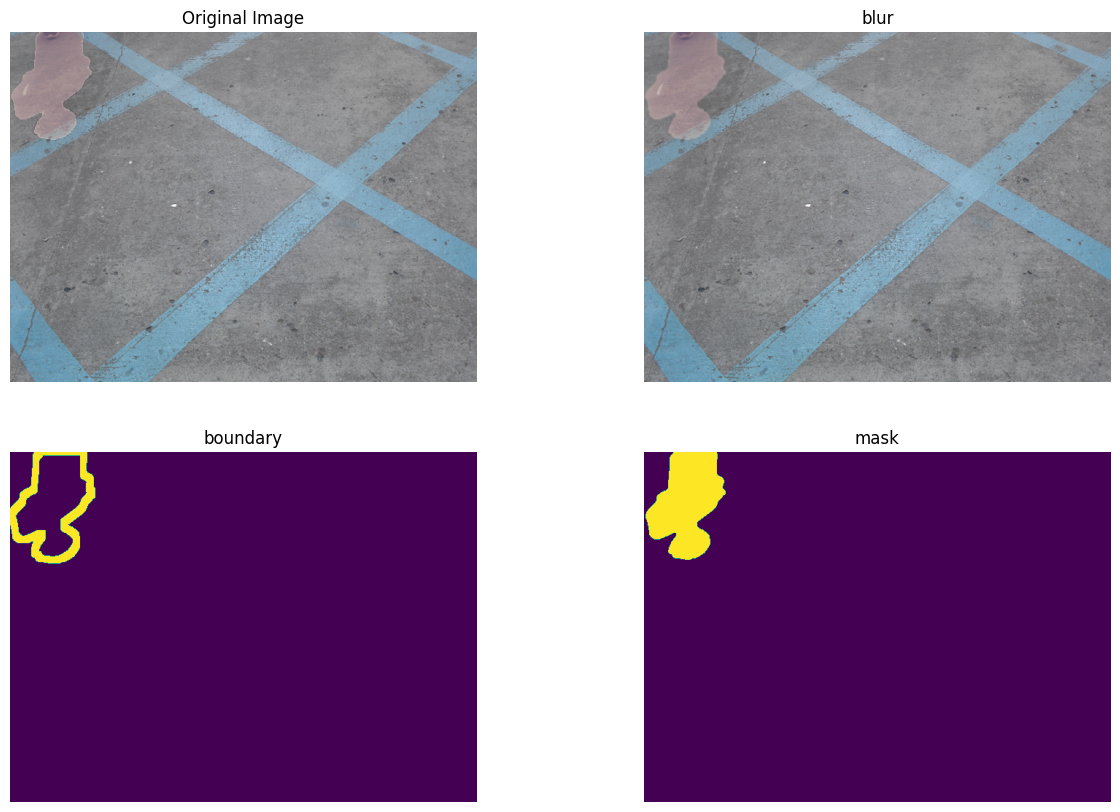

In [189]:
img_original = np.squeeze(img_tensor.cpu().numpy()).transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
mask_original = m_tensor.cpu().numpy()
border_original = border_mask.cpu().numpy()#.transpose(1, 2, 0)
fin_original = np.squeeze(blurred_innested_img.cpu().numpy()).transpose(1, 2, 0)

# Plot the images using matplotlib
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].imshow(img_original)
axes[0][0].set_title('Original Image')
axes[0][0].axis('off')

axes[0][1].imshow(fin_original.squeeze())
axes[0][1].set_title('blur')
axes[0][1].axis('off')

axes[1][0].imshow(border_original.squeeze())
axes[1][0].set_title('boundary')
axes[1][0].axis('off')

axes[1][1].imshow(mask_original)
axes[1][1].set_title('mask')
axes[1][1].axis('off')

plt.show()

## Penumbra

In [4]:
path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_A/123-1.png'
mask = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_B/123-1.png'
path_gt = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_C/123-1.png'

# Read the original image and ground truth
img_original = read_image(path)
img_mask = read_image(mask)[:,:,1]
gt_original = read_image(path_gt)

# Convert numpy arrays to PyTorch tensors and ensure they're of type float
img_tensor = torch.from_numpy(img_original).float()
m_tensor = torch.from_numpy(img_mask).float()
gt_tensor = torch.from_numpy(gt_original).float()

# Ensure img_tensor and gt_tensor have shape (C, H, W)
if img_tensor.ndimension() == 3 and img_tensor.shape[2] == 3:  # (H, W, C)
    img_tensor = img_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if m_tensor.ndimension() == 3 and m_tensor.shape[2] == 2:  # (H, W, C)
    m_tensor = m_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if gt_tensor.ndimension() == 3 and gt_tensor.shape[2] == 3:  # (H, W, C)
    gt_tensor = gt_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

In [5]:
def penumbra(mask):
    kernel_size = 2
    kernel = torch.ones((1, 1, kernel_size, kernel_size)).float()
    padding = kernel_size // 2
    
    eroded_mask = F.conv2d(mask.float(), kernel, padding=padding)
    eroded_mask = torch.where(eroded_mask >= kernel_size**2, 1.0, 0.0)
    eroded_mask = eroded_mask[:, :, :mask.size(2), :mask.size(3)]

    dilated_mask = F.conv2d(mask.float(), kernel, padding=padding)
    dilated_mask = torch.where(dilated_mask > 0, 1.0, 0.0)
    dilated_mask = dilated_mask[:, :, :mask.size(2), :mask.size(3)]

    border_mask1 = mask - eroded_mask
    border_mask2 = dilated_mask - mask
    penumbra = border_mask1 + border_mask2

    kernel_size =  np.clip(int(penumbra.sum().item() / 100), 10, 30)
    print(kernel_size)
    kernel = torch.ones((1, 1, kernel_size, kernel_size)).float()
    padding = kernel_size // 2
    
    eroded_mask = F.conv2d(mask.float(), kernel, padding=padding)
    eroded_mask = torch.where(eroded_mask >= kernel_size**2, 1.0, 0.0)
    eroded_mask = eroded_mask[:, :, :mask.size(2), :mask.size(3)]

    dilated_mask = F.conv2d(mask.float(), kernel, padding=padding)
    dilated_mask = torch.where(dilated_mask > 0, 1.0, 0.0)
    dilated_mask = dilated_mask[:, :, :mask.size(2), :mask.size(3)]

    border_mask1 = mask - eroded_mask
    border_mask2 = dilated_mask - mask
    penumbra = border_mask1 + border_mask2

    return penumbra

In [26]:
from scipy.spatial import ConvexHull

def penumbra2(mask):
    points = torch.nonzero(mask)
    points_np = points.numpy()
    hull = ConvexHull(points_np)
    hull_vertices = points_np[hull.vertices]
    perimeter = 0.0
    for i in range(len(hull_vertices)):
        point1 = hull_vertices[i]
        point2 = hull_vertices[(i + 1) % len(hull_vertices)]
        distance = np.linalg.norm(point1 - point2)
        perimeter += distance

    print(perimeter)
    kernel_size =  np.clip(int(perimeter / 100), 10, 30)
    print(kernel_size)
    kernel = torch.ones((1, 1, kernel_size, kernel_size)).float()
    padding = kernel_size // 2

    mask = mask.expand(1, 1, -1, -1)
    
    eroded_mask = F.conv2d(mask.float(), kernel, padding=padding)
    eroded_mask = torch.where(eroded_mask >= kernel_size**2, 1.0, 0.0)
    eroded_mask = eroded_mask[:, :, :mask.size(2), :mask.size(3)]

    dilated_mask = F.conv2d(mask.float(), kernel, padding=padding)
    dilated_mask = torch.where(dilated_mask > 0, 1.0, 0.0)
    dilated_mask = dilated_mask[:, :, :mask.size(2), :mask.size(3)]

    border_mask1 = mask - eroded_mask
    border_mask2 = dilated_mask - mask
    penumbra = border_mask1 + border_mask2

    return penumbra, list(hull_vertices)

In [101]:
import torch
from scipy.spatial import ConvexHull
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

def penumbra3(mask_):
    mask = mask_.clone()
    mask_np = mask.numpy().astype(np.uint8)
    labeled_mask, num_features = ndimage.label(mask_np)

    perimeters = []
    hull_coordinates = []

    for i in range(1, num_features + 1):
        # Ottieni le coordinate dei punti per ciascuna regione etichettata
        region_points = np.argwhere(labeled_mask == i)
        
        # Calcola l'involucro convesso solo se ci sono abbastanza punti
        if region_points.shape[0] < 3:
            continue
        
        # Calcola l'involucro convesso
        hull = ConvexHull(region_points)
        hull_vertices = region_points[hull.vertices]

        # Calcola il perimetro dell'involucro convesso
        perimeter = 0.0
        for j in range(len(hull_vertices)):
            point1 = hull_vertices[j]
            point2 = hull_vertices[(j + 1) % len(hull_vertices)]
            distance = np.linalg.norm(point1 - point2)
            perimeter += distance
        
        perimeters.append(perimeter)
        hull_coordinates.append(hull_vertices)
    sum_per = sum(perimeters)

    print(sum_per)
    kernel_size =  np.clip(int(sum_per / 50), 10, 30)
    print(kernel_size)
    kernel = torch.ones((1, 1, kernel_size, kernel_size)).float()
    padding = kernel_size // 2

    mask = mask.expand(1, 1, -1, -1)
    
    eroded_mask = F.conv2d(mask.float(), kernel, padding=padding)
    eroded_mask = torch.where(eroded_mask >= kernel_size**2, 1.0, 0.0)
    eroded_mask = eroded_mask[:, :, :mask.size(2), :mask.size(3)]

    dilated_mask = F.conv2d(mask.float(), kernel, padding=padding)
    dilated_mask = torch.where(dilated_mask > 0, 1.0, 0.0)
    dilated_mask = dilated_mask[:, :, :mask.size(2), :mask.size(3)]

    border_mask1 = mask - eroded_mask
    border_mask2 = dilated_mask - mask
    penumbra = border_mask1 + border_mask2

    return penumbra, hull_coordinates

In [14]:
mask_exp = m_tensor.expand(1, 1, -1, -1)
penumbra_img = penumbra2(m_tensor.squeeze())

12


1397.659710517788
27


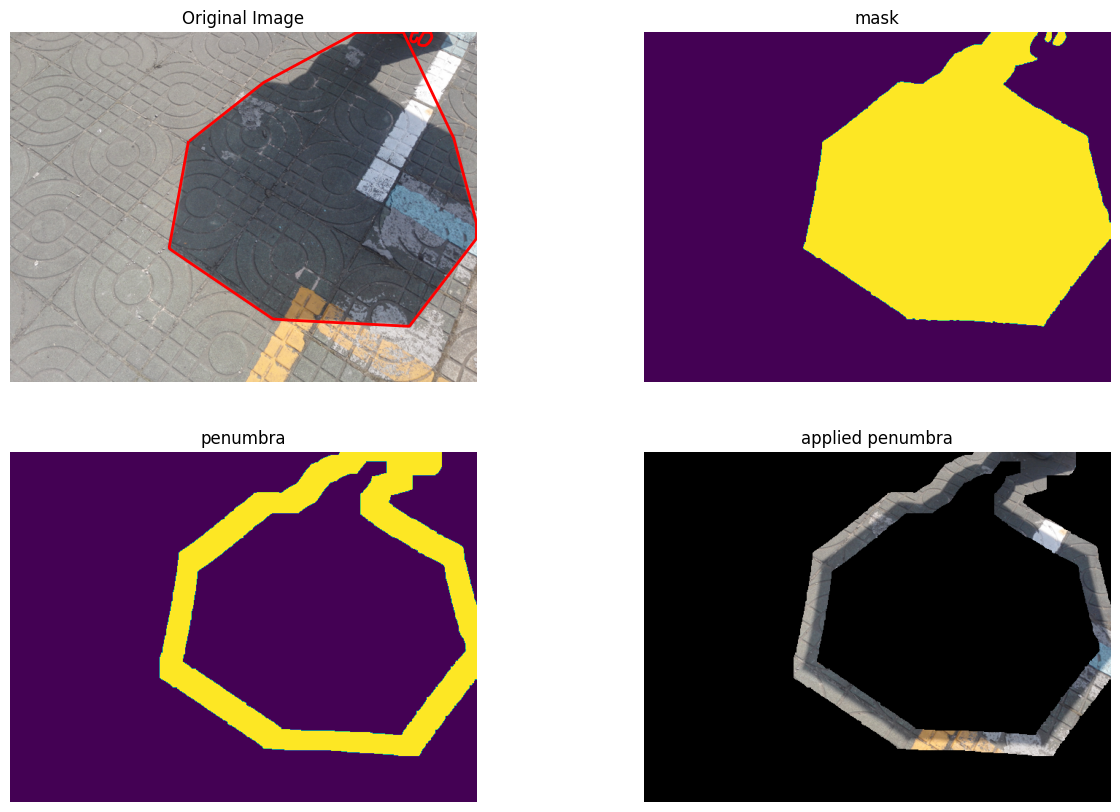

In [104]:
path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_A/100-2.png'
mask = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_B/100-2.png'
path_gt = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_C/100-2.png'

# Read the original image and ground truth
img_original = read_image(path)
img_mask = read_image(mask)[:,:,1]
gt_original = read_image(path_gt)

# Convert numpy arrays to PyTorch tensors and ensure they're of type float
img_tensor = torch.from_numpy(img_original).float()
m_tensor = torch.from_numpy(img_mask).float()
gt_tensor = torch.from_numpy(gt_original).float()

# Ensure img_tensor and gt_tensor have shape (C, H, W)
if img_tensor.ndimension() == 3 and img_tensor.shape[2] == 3:  # (H, W, C)
    img_tensor = img_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if m_tensor.ndimension() == 3 and m_tensor.shape[2] == 2:  # (H, W, C)
    m_tensor = m_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if gt_tensor.ndimension() == 3 and gt_tensor.shape[2] == 3:  # (H, W, C)
    gt_tensor = gt_tensor.permute(2, 0, 1)  # Convert to (C, H, W)



penumbra_img, vertex = penumbra3(m_tensor)

x_coords =[]
y_coords =[]

for j in range(len(vertex)):
    x =[]
    y = []
    for i in range(len(vertex[j])):
        x.append(vertex[j][i][1])
        y.append(vertex[j][i][0]) 
    x_coords.append(x)
    y_coords.append(y)


img_original = np.squeeze(img_tensor.cpu().numpy()).transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
mask_original = m_tensor.cpu().numpy()
penumbra_fin = np.squeeze(penumbra_img.cpu().numpy())

penumbra_fin = penumbra_fin.astype(np.uint8)

if penumbra_fin.shape != img_original.shape[:2]:
    penumbra_fin = cv2.resize(penumbra_fin, (img_original.shape[1], img_original.shape[0]))

nw = cv2.bitwise_and(img_original, img_original, mask=penumbra_fin)


# Plot the images using matplotlib
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].imshow(img_original)
axes[0][0].set_title('Original Image')
axes[0][0].axis('off')
for w in range(len(x_coords)):
    axes[0][0].plot(x_coords[w], y_coords[w], color='red', linewidth=2)

axes[0][1].imshow(mask_original)
axes[0][1].set_title('mask')
axes[0][1].axis('off')

axes[1][0].imshow(penumbra_fin.squeeze())
axes[1][0].set_title('penumbra')
axes[1][0].axis('off')

axes[1][1].imshow(nw)
axes[1][1].set_title('applied penumbra')
axes[1][1].axis('off')

plt.show()

## Immgagine per LPIPS

In [190]:
import os
import numpy as np
import random

In [191]:
root_dir = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test'

In [192]:
shadow_images = os.listdir(os.path.join(root_dir, root_dir.split('/')[-1] + '_A'))
shadow_masks = os.listdir(os.path.join(root_dir, root_dir.split('/')[-1] + '_B'))
shadow_free_images = os.listdir(os.path.join(root_dir, root_dir.split('/')[-1] + '_C'))

In [193]:
index=1

In [194]:
s = "123-1.png"

In [195]:
path = os.path.join('/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_A', s)#, shadow_images[index])
mask = os.path.join('/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_B', s)#, shadow_images[index])
path_gt = os.path.join('/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_C', s)#, shadow_images[index])

# Read the original image and ground truth
img_original = read_image(path)
img_mask = read_image(mask)[:,:,1]
gt_original = read_image(path_gt)

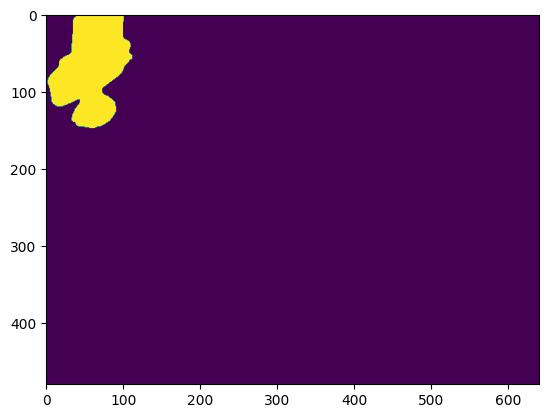

In [196]:
plt.imshow(img_mask)

In [197]:
import numpy as np

def crop_region(shadow_mask, m = 40):
    """Crop the image around the scattered points in the mask ensuring minimum size"""
    # Find all points where the mask is 1
    points = np.argwhere(shadow_mask == 1)
    
    # Extract the bounding box around all scattered points where mask is 1
    min_w = np.min(points[:, 1])
    min_h = np.min(points[:, 0])
    max_w = np.max(points[:, 1])
    max_h = np.max(points[:, 0])
    
    # Ensure the bounding box has a minimum size
    width = max_w - min_w + 1
    height = max_h - min_h + 1

    if width < m:
        pad_w = (m - width) // 2
        min_w = max(0, min_w - pad_w)
        max_w = min(shadow_mask.shape[1] - 1, max_w + pad_w + (m - width) % 2)
        
    if height < m:
        pad_h = (m - height) // 2
        min_h = max(0, min_h - pad_h)
        max_h = min(shadow_mask.shape[0] - 1, max_h + pad_h + (m - height) % 2)

    # Return the bounding box coordinates as a numpy array
    bbox = np.array([min_h, max_h, min_w, max_w])
    return bbox


In [198]:
from PIL import Image
cordinate = crop_region(img_mask)
cropped_image = img_mask[ cordinate[0]:cordinate[1], cordinate[2]:cordinate[3]]

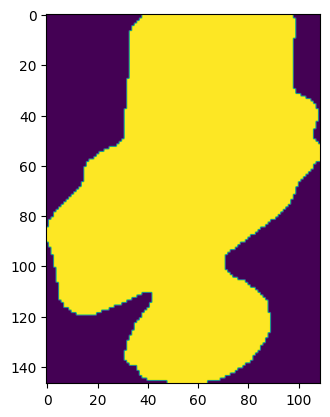

In [199]:
plt.imshow(cropped_image)

## Mask correction

In [200]:
from scipy.ndimage import label, find_objects, binary_closing, generate_binary_structure

def remove_small_objects(mask, min_size):
    # Label connected components
    labeled_mask, num_features = label(mask)
    
    # Create an output mask to keep only the large components
    output_mask = np.zeros_like(mask, dtype=bool)
    
    # Iterate through each component and keep only those larger than min_size
    for i in range(1, num_features + 1):
        component = (labeled_mask == i)
        if np.sum(component) >= min_size:
            output_mask = np.logical_or(output_mask, component)
    
    return output_mask

def fill_small_holes(mask, max_size):
    # Invert the mask to treat holes as objects
    inverted_mask = np.logical_not(mask)
    
    # Label connected components (holes) in the inverted mask
    labeled_holes, num_features = label(inverted_mask)
    
    # Create an output mask to fill only the small holes
    output_mask = np.copy(mask)
    
    # Iterate through each hole and fill only those smaller than max_size
    for i in range(1, num_features + 1):
        hole = (labeled_holes == i)
        if np.sum(hole) <= max_size:
            output_mask = np.logical_or(output_mask, hole)
    
    return output_mask

def process_mask(mask, min_size=100, max_size=100):
    # Remove small objects (1s surrounded by 0s)
    cleaned_mask = remove_small_objects(mask, min_size)
    final_mask = fill_small_holes(cleaned_mask, max_size)
    
    return final_mask

In [201]:
s = '123-1.png'
mask = os.path.join('/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/test/test_B', s)#, shadow_images[index])

img_mask = read_image(mask)[:,:,1]

In [202]:
processed_mask = process_mask(img_mask, min_size=100, max_size=100)

In [203]:
cordinate = crop_region(img_mask)
cropped_image = img_mask[ cordinate[0]:cordinate[1], cordinate[2]:cordinate[3]]
cordinate2 = crop_region(processed_mask)
cropped_image2 = processed_mask[cordinate2[0]:cordinate2[1], cordinate2[2]:cordinate2[3]]

(-0.5, 108.5, 146.5, -0.5)

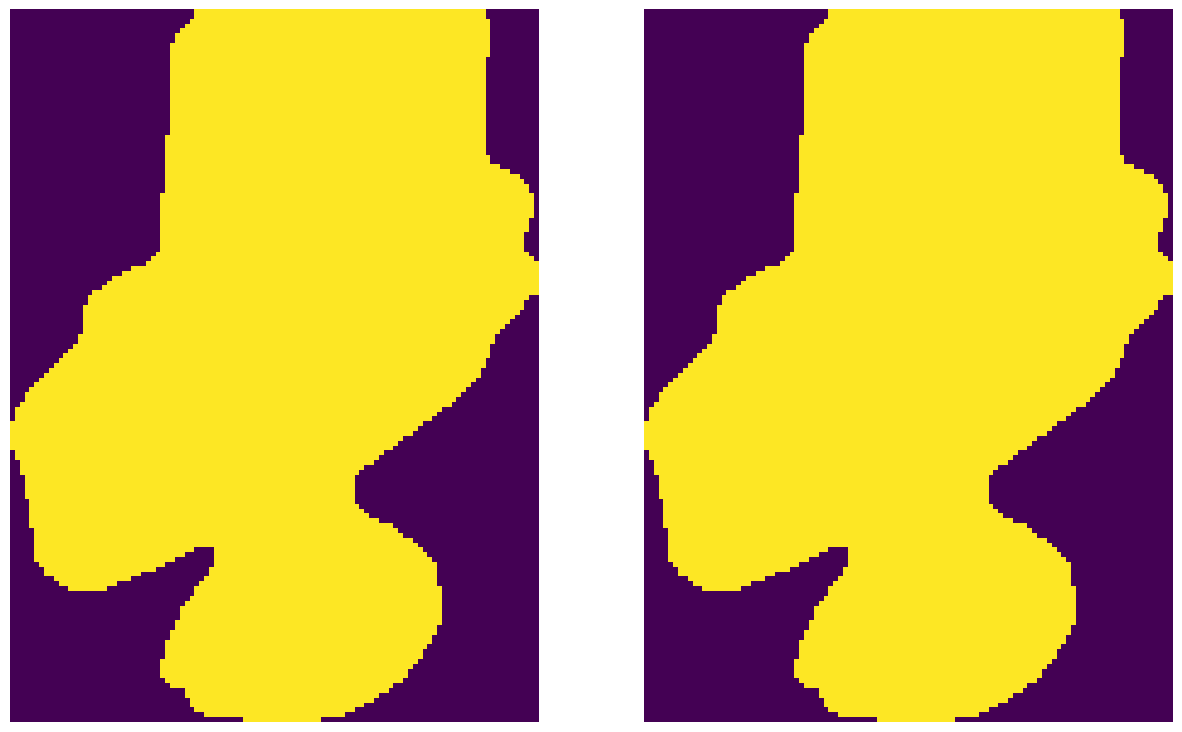

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(cropped_image)
axes[0].axis('off')

axes[1].imshow(cropped_image2)
axes[1].axis('off')


## Prova Data loader

In [212]:
from dataloader_crop import ISTDDataset
import os

In [213]:
dataset_path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset'

In [214]:
train_dataset = ISTDDataset(os.path.join(dataset_path, "test"), size=(512, 512), aug=True, fix_color=True)
val_dataset = ISTDDataset(os.path.join(dataset_path, "test"), aug=False, fix_color=True)

(-0.5, 511.5, 511.5, -0.5)

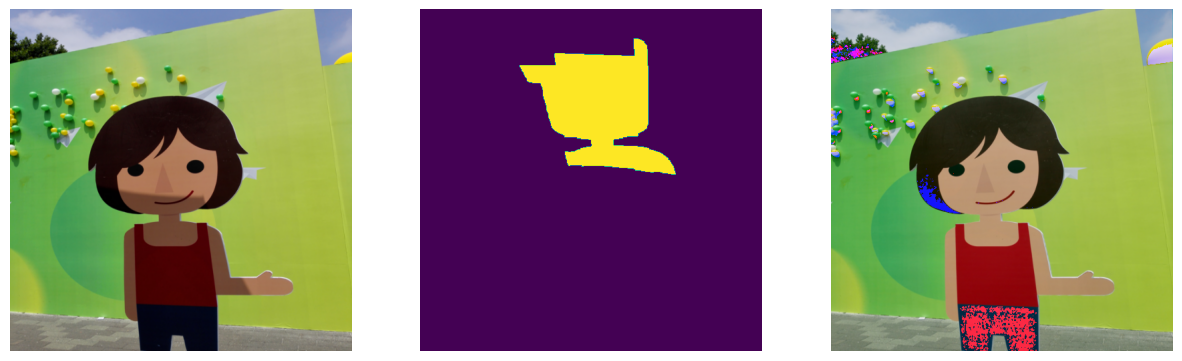

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow((train_dataset[0]['shadow_image'].transpose(1, 2, 0)*255).astype(np.uint8))
axes[0].axis('off')

axes[1].imshow(train_dataset[0]['shadow_mask'].transpose(1, 2, 0).astype(np.uint8))
axes[1].axis('off')

axes[2].imshow((train_dataset[0]['shadow_free_image'].transpose(1, 2, 0)*255).astype(np.uint8))
axes[2].axis('off')

In [21]:
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import MultiStepLR
lr = 0.002  #This is the initial learning rate
model = nn.Linear(10,1)
optimizer = optim.Adam(model.parameters(),lr = lr)
lr_scheduler = lr_scheduler.ExponentialLR(optimizer,gamma = 0.98) #Similar to StepLR when step_size = 1
#lr_scheduler = MultiStepLR(optimizer, milestones=list(range(1, 17)), gamma=0.5)
epochs = 300
for epoch in range(1,epochs+1):
    optimizer.step()
    lr_scheduler.step()
    print(optimizer.state_dict()['param_groups'][0]['lr'],epoch,sep = "->epoch ")

0.00196->epoch 1
0.0019207999999999999->epoch 2
0.0018823839999999998->epoch 3
0.0018447363199999996->epoch 4
0.0018078415935999996->epoch 5
0.0017716847617279996->epoch 6
0.0017362510664934395->epoch 7
0.0017015260451635707->epoch 8
0.0016674955242602992->epoch 9
0.001634145613775093->epoch 10
0.0016014627014995912->epoch 11
0.0015694334474695994->epoch 12
0.0015380447785202074->epoch 13
0.0015072838829498032->epoch 14
0.0014771382052908072->epoch 15
0.001447595441184991->epoch 16
0.0014186435323612911->epoch 17
0.0013902706617140654->epoch 18
0.001362465248479784->epoch 19
0.0013352159435101884->epoch 20
0.0013085116246399848->epoch 21
0.001282341392147185->epoch 22
0.0012566945643042412->epoch 23
0.0012315606730181564->epoch 24
0.0012069294595577933->epoch 25
0.0011827908703666375->epoch 26
0.0011591350529593046->epoch 27
0.0011359523519001186->epoch 28
0.0011132333048621162->epoch 29
0.0010909686387648738->epoch 30
0.0010691492659895762->epoch 31
0.0010477662806697846->epoch 32
0.0